# **Accessing Ocean Observations with ValidOcean**

#### **Description:**
This tutorial notebook explores how to use the ModelValidator class to access ocean observations stored in the cloud.

To demonstrate how to access ocean observations, we will first introduce the core concept of **DataLoaders**, which are responsible for loading data from Analysis-Ready Cloud Optimised (ARCO) zarr stores in the JASMIN Object Store.

### **Contact:**
Ollie Tooth (oliver.tooth@noc.ac.uk)

In [1]:
# -- Import required libraries -- #
import xarray as xr
from ValidOcean import ModelValidator
from ValidOcean import DataLoader

/home/otooth/miniconda3/envs/env_nemo_validation/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


#### **Introducing DataLoaders**

One of the foundational concepts behind the ValidOcean library was to enable users to access ocean observations data stored in [zarr](https://zarr.dev) format in the cloud through a method that is independent of their local or remote machine.

A major benefit of storing ocean observations in cloud object storage is that users can then directly access this data via a read-only URL.

In ValidOcean, we've taken this data accessibility one step further by creating DataLoaders which load ocean observations from the JASMIN object store and pre-process them into a standardised [xarray Dataset](https://docs.xarray.dev/en/latest/user-guide/data-structures.html).

To understand how DataLoaders work, let's start with an example of accessing the National Snow & Ice Data Centre (NSIDC) Sea Ice Index version 3...

In [2]:
# Create an empty ModelValidator object:
mv = ModelValidator()

# Load NSIDC Arctic Sea Ice Concentration data:
mv.load_observations(obs_name='NSIDC',
                     var_name='siconc',
                     region='arctic',
                     )

/dssgfs01/working/otooth/Diagnostics/ValidOcean/ValidOcean/processing.py:208: RuntimeWarning: [longitude: -180, 180; latitude: -90, 90] bounds are outside the range of available observations data [longitude: -180.0, 179.81397539549246; latitude: 31.102671752463447, 89.83681599961737].
  warnings.warn(warning_message, RuntimeWarning)



<ModelValidator>

-- Model Data --

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*

-- Observations --

<xarray.Dataset> Size: 605MB
Dimensions:            (y_nsidc: 448, x_nsidc: 304, time_nsidc: 553)
Coordinates:
    band_nsidc         int64 8B 1
    lat_nsidc          (y_nsidc, x_nsidc) float64 1MB 31.1 31.2 ... 34.58 34.47
    lon_nsidc          (y_nsidc, x_nsidc) float64 1MB 168.3 168.1 ... -9.999
    spatial_ref_nsidc  int64 8B 0
  * time_nsidc         (time_nsidc) datetime64[ns] 4kB 1978-11-15 ... 2025-01-15
  * x_nsidc            (x_nsidc) float64 2kB -3.838e+06 -3.812e+06 ... 3.738e+06
  * y_nsidc            (y_nsidc) float64 4kB 5.838e+06 5.812e+06 ... -5.338e+06
Data variables:
    siconc_nsidc       (time_nsidc, y_nsidc, x_nsidc) float64 603MB dask.array<chunksize=(12, 448, 304), meta=np.ndarray>

-- Results --

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*

-- Stats --

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables

In the example above, we created an empty ``ModelValidator()`` object and then used the ``.load_observations()`` method to load a lazy Dataset (i.e., comprised of [dask](https://www.dask.org) arrays which are not yet loaded into memory) including Arctic sea ice concentration data for the entire period of available observations (1978-2025).

Behind the scenes, the ``.load_observations()`` method calls the private ``._load_obs_data()`` method, which in-turn creates an instance of the ``NSIDCLoader()`` class and calls its ``._load_data()`` method. This is the standard process for loading ocean observations data in ValidOcean, including by the plotting and compute methods introduced in Examples 2 & 3. The resulting ocean observations dataset is accessible via the ``.obs`` attribute.

Let's consider another example where we would like to load monthly sea surface temperature observations from the Met Office Hadley Centre Monthly Median (HadISST1) product for a regional subdomain and a custom time window...

In [3]:
# Create a new, empty ModelValidator object:
mv = ModelValidator()

# Load NOAA OISSTv2 SST data:
mv.load_observations(obs_name='HadISST',
                     var_name='sst',
                     lon_bounds=(-75, 5),
                     lat_bounds=(20, 90),
                     time_bounds=slice('2020-01', '2025-12'),
                     freq=None,
                     )

/dssgfs01/working/otooth/Diagnostics/ValidOcean/ValidOcean/processing.py:131: RuntimeWarning: time_bounds 2020-01 - 2025-12 are outside the range of available observations data 1870-01-16 - 2024-09-16.
  warnings.warn(warning_message, RuntimeWarning)



<ModelValidator>

-- Model Data --

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*

-- Observations --

<xarray.Dataset> Size: 1MB
Dimensions:       (lat_hadisst: 70, lon_hadisst: 80, time_hadisst: 57)
Coordinates:
  * lat_hadisst   (lat_hadisst) float32 280B 89.5 88.5 87.5 ... 22.5 21.5 20.5
  * lon_hadisst   (lon_hadisst) float32 320B -74.5 -73.5 -72.5 ... 2.5 3.5 4.5
  * time_hadisst  (time_hadisst) datetime64[ns] 456B 2020-01-16T12:00:00 ... ...
Data variables:
    sst_hadisst   (time_hadisst, lat_hadisst, lon_hadisst) float32 1MB dask.array<chunksize=(57, 70, 80), meta=np.ndarray>

-- Results --

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*

-- Stats --

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*

#### **Visualising Ocean Observations**

Let's make a quick visualisation of the time-mean regional OISSTv2 sea surface temperatures by accessing the data directly via the ``.obs`` attribute...

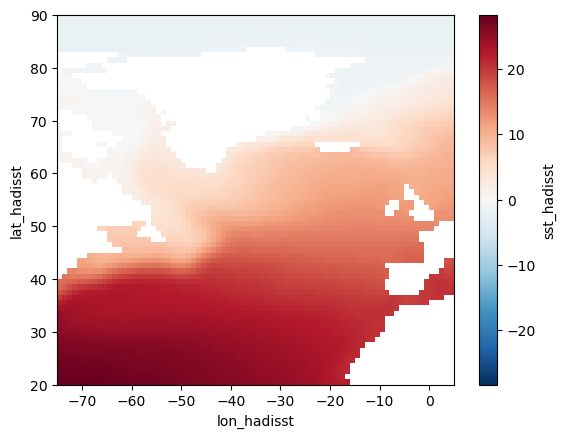

In [4]:
# Plotting the time-mean SST:
mv.obs['sst_hadisst'].mean(dim='time_hadisst').plot()

#### **Custom DataLoaders**

A major advantage of the generalised approach to loading observations introduced above is that users can easily extend the ValidOcean library by adding custom DataLoaders.

Below we can see an example DataLoader which inherits the DataLoader Abstract Base Class & could be used to load ocean observations from a local file system or alternative cloud object storage provider...

In [5]:
class MyLoader(DataLoader):
    """
    Example DataLoader to load ocean observations stored
    on a local filesystem or cloud object storage.

    Parameters
    ----------
    var_name : str, default: ``my_variable``
        Name of variable to load from example ocean observations.
        Options include ``my_variable``, ``my_other_variable``.
    time_bounds : slice, str, default: None
        Time bounds to compute climatology using example ocean observations.
        Default is ``None``, meaning the entire dataset is considered.
    lon_bounds : tuple, default: None
        Longitude bounds to extract from example ocean observations.
        Default is ``None``, meaning the entire longitude range is loaded.
    lat_bounds : tuple, default: None
        Latitude bounds to extract from example ocean observations.
        Default is ``None``, meaning the entire latitude range is loaded.
    freq : str, default: ``None``
        Climatology frequency of the example ocean observations.
        Options include ``None``, ``total``, ``seasonal``, ``monthly``,
        ``jan``, ``feb`` etc. for individual months. Default is``None``
        meaning no climatology is computed from monthly data.
    """
    def __init__(self,
                 var_name: str = 'my_variable',
                 region: str | None = None,
                 time_bounds: slice | str | None = None,
                 lon_bounds: tuple | None = None,
                 lat_bounds: tuple | None = None,
                 freq: str | None = None,
                 ):

        # -- Verify Inputs -- #
        if var_name not in ['my_variable', 'my_other_variable']:
            raise ValueError("``var_name`` must be one of 'my_variable', 'my_other_variable'.")

        # -- Initialise DataLoader -- #
        super().__init__(var_name=var_name,
                         region=region,
                         source='jasmin-os', # <- Modify to your cloud object storage or local filepath.
                         time_bounds=time_bounds,
                         lon_bounds=lon_bounds,
                         lat_bounds=lat_bounds,
                         freq=freq)

    def _load_data(self) -> xr.DataArray:
        """
        Load example ocean observations data & optionally
        compute climatology using cloud object storage or
        a local filesystem.

        Returns
        -------
        xarray.DataArray
            Dataset storing example ocean observations data
            or option climatology at specified frequency.
        """
        # Load data from our chosen source:
        url = f"{self._source}/Example/Example_global_monthly_1980_2025/"

        # Data to inherit source attributes:
        source = xr.open_zarr(url, consolidated=True) # <- Alternatively, use xr.open_dataset() for NetCDF files.
        data = source[self._var_name]
        data.attrs = source.attrs

        # Extract observations for specified time, longitude and latitude bounds:
        data = _apply_spatial_bounds(data, lon_bounds=self._lon_bounds, lat_bounds=self._lat_bounds)

        if isinstance(self._time_bounds, slice):
            data = _apply_time_bounds(data, time_bounds=self._time_bounds)

        # Compute climatology:
        if self._freq is not None:
            data = _compute_climatology(data, freq=self._freq)

        # Add spatial bounds to attributes:
        data.attrs["lon_bounds"], data.attrs["lat_bounds"] = _get_spatial_bounds(lon=data["lon"], lat=data["lat"])

        return data


#### **Anatomy of a Custom DataLoader**

Initially, there looks like a lot of code in the example DataLoader shown above, but actually there are only two components needed to create a DataLoader.

1. **Defining our Class with an ``__init__()`` method.**

- This is how ValidOcean will create an instance of the class. Notice that we use ``super().__init__()`` to pass the input arguments to our ``MyLoader()`` class to the ``DataLoader()`` abstract base class that it inherits. This step ensures that our new DataLoader conforms to the standards required for use in ValidOcean.

2. **Defining a ``._load_data()`` method.**

- This method is a requirement for every DataLoader and should use the attributes of the DataLoader to load ocean observations as an xarray Dataset. In the example above, we have included several useful pre-processing steps that you will find in each of the core DataLoaders included with ValidOcean.


#### **Using a Custom DataLoader**

To use our custom DataLoader in a validation workflow, we can pass the ``MyLoader()`` object as the ``dataloader`` argument when creating a ModelValidator() object...

In [6]:
ModelValidator(mdl_data=None, dataloader=MyLoader())


<ModelValidator>

-- Model Data --

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*

-- Observations --

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*

-- Results --

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*

-- Stats --

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*

#### **Next Steps...**

In this tutorial, we have seen how to use the ModelValidator object to access ocean observations stored in the cloud & how to add custom DataLoaders to extend the ValidOcean library.

Next, start exploring the capabilities of ValidOcean for accelerating your own ocean model validation workflows!